# Run Watson Classifiers in Real-time Configuration

###### Author: Alberto Nieto
###### Organization: Esri
###### Date: June, 2017

![Machine Learning Integration](../img/integration2.jpg)

# Pseudocode

Goal: To run classification on the real-time snapshots provided by Cobb County, storing the outputs on a hosted service. 

Procedure:

1. Routine Setup

    1a. Authentication
        - IBM Watson
        - ArcGIS Online
    
    1b. Retrieve Models
    
    1c. Retrieve input images location
    
    1d. Retrieve target hosted service
    
2. Set Helper Functions

    2a. Get latest snapshot 
    
    2b. Classify Image
    
    2c. Update hosted service feature
    
    2d. Add hosted service feature
     
3. Iteration

    For each camera:
    
        3a. Get latest snapshot

        3b. Classify image
        
        3c. Update/Add feature to service

# 1. Routine Setup

Imported modules

In [1]:
import os
from watson_developer_cloud import VisualRecognitionV3
import arcgis
import pandas as pd
from copy import deepcopy
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import Image, display
from IPython.core.display import HTML 
import scipy.misc
from datetime import datetime, timedelta
import time

workspace

In [2]:
workspace_dir = os.getcwd()+"\\Temp"

## IBM Watson Authentication

In [3]:
visual_recognition = VisualRecognitionV3(
    '2018-03-19',
    iam_api_key=os.environ['BLUEMIX_API_KEY'])

## ArcGIS Authentication

In [4]:
gis = arcgis.gis.GIS(os.environ['ESRIFEDERAL_URL'], username="Anieto_esrifederal")

Enter password: ········


## 1b. Retrieve Models

In [5]:
models_dict = visual_recognition.list_classifiers(verbose=True); models_dict

{'classifiers': [{'classes': [{'class': 'low'},
    {'class': 'medium'},
    {'class': 'high'}],
   'classifier_id': 'Esri_Classification_CobbCounty_371717976',
   'core_ml_enabled': True,
   'created': '2018-06-26T15:08:09.890Z',
   'name': 'Esri_Classification_CobbCounty_Cam130',
   'owner': '52d3c878-5f0a-44c6-b191-358d19be7bc5',
   'status': 'ready',
   'updated': '2018-06-26T15:08:09.890Z'},
  {'classes': [{'class': 'low'}, {'class': 'medium'}, {'class': 'high'}],
   'classifier_id': 'Esri_Classification_CobbCounty_361684145',
   'core_ml_enabled': True,
   'created': '2018-06-26T15:06:56.039Z',
   'name': 'Esri_Classification_CobbCounty_Cam129',
   'owner': '52d3c878-5f0a-44c6-b191-358d19be7bc5',
   'status': 'ready',
   'updated': '2018-06-26T15:06:56.039Z'},
  {'classes': [{'class': 'low'}, {'class': 'medium'}, {'class': 'high'}],
   'classifier_id': 'Esri_Classification_CobbCounty_1256542849',
   'core_ml_enabled': True,
   'created': '2018-06-26T15:00:48.899Z',
   'name': 'Es

In [6]:
models_df = pd.DataFrame.from_dict(models_dict['classifiers']); models_df

,classes,classifier_id,core_ml_enabled,created,name,owner,status,updated
0,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_371717976,True,2018-06-26T15:08:09.890Z,Esri_Classification_CobbCounty_Cam130,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-26T15:08:09.890Z
1,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_361684145,True,2018-06-26T15:06:56.039Z,Esri_Classification_CobbCounty_Cam129,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-26T15:06:56.039Z
2,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_1256542849,True,2018-06-26T15:00:48.899Z,Esri_Classification_CobbCounty_Cam128,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-26T15:00:48.899Z


In [7]:
model_128_name = 'Esri_Classification_CobbCounty_Cam128_v2'
model_129_name = 'Esri_Classification_CobbCounty_Cam129_v2'
model_130_name = 'Esri_Classification_CobbCounty_Cam130_v2'

In [8]:
model_128_id = models_df.loc[models_df['name'] == model_128_name, 'classifier_id'].values[0]
model_129_id = models_df.loc[models_df['name'] == model_129_name, 'classifier_id'].values[0]
model_130_id = models_df.loc[models_df['name'] == model_130_name, 'classifier_id'].values[0]

In [9]:
cameraid_model_dict = {
    "128": model_128_id,
    "129": model_129_id,
    "130": model_130_id
}

## 1c. Retrieve input images location

In [10]:
images_url = r"https://www.cobbgis.org/openimage/bravescam"
cams = ["128", "129", "130"]
cam_urls = ["{0}/Cam{1}".format(images_url, cam) for cam in cams]; cam_urls

['https://www.cobbgis.org/openimage/bravescam/Cam128',
 'https://www.cobbgis.org/openimage/bravescam/Cam129',
 'https://www.cobbgis.org/openimage/bravescam/Cam130']

## 1d. Retrieve target hosted service

<Item title:"SunTrust_PedestrianFlows_EventSimulation_C" type:Feature Layer Collection owner:Anieto_esrifederal>
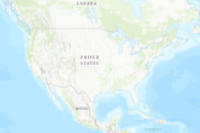

In [37]:
target_service_name = "SunTrust_PedestrianFlows_EventSimulation_C"
# Set schema of target point service
label_attribute_name = 'pedestrian_density'
camera_id_attribute_name = 'camera_id'
source_image_attribute_name = 'source_image'
object_point_srvc = gis.content.search(target_service_name, item_type="Feature Layer")[0]
object_point_srvc

# 2. Set Helper Functions

## 2a. Get Latest Snapshot

In [27]:
def get_latest_snapshot(images_webpage_url, workspace):
    
    """
    Retrieve the latest image from the Cobb County SunTrust Park images repository, store locally, and return path
    :param images_webpage_url: String - Full path to HTTPS url for SunTrust Park images repository
    :param workspace: String - Full path to directory where image can be stored
    :return: String - Full directory path to locally stored image
    """ 
    
    # Use requests module to retrieve the page
    page = requests.get(images_webpage_url, verify=False)
    # Use beautifulsoup module to scrape content
    soup = BeautifulSoup(page.content)
    # Build list of links
    links = []
    for link in soup.findAll('a'):
        if link.get('href') != "/openimage/bravescam/":
            links.append(link.get('href'))      
    # Retrieve latest image
    latest_image_url = "{0}{1}".format("https://www.cobbgis.org", links[-1])
    # Write image locally to workspace
    latest_image_path = "{0}\\temp_latest_image.jpg".format(workspace)
    with open(latest_image_path, 'wb') as handle:
        response = requests.get(latest_image_url, stream=True)
        if not response.ok:
            print(response)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)
    if os.path.isfile(latest_image_path):           
        return latest_image_path, latest_image_url
    else:
        return None

In [28]:
# Test function
get_latest_snapshot(cam_urls[0], workspace_dir)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


('C:\\Users\\anieto\\Documents\\GitHub\\watson-crowd-classifier\\Temp\\temp_latest_image.jpg',
 'https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-27_18-16-49-03.jpg')

## 2b. Classify Image

In [38]:
def classify_image(image, classifier_id, threshold_val='0.15', display_image=False):
    """
    Pass a locally stored image to a Watson classifier and return the classification results
    :param image: String - Full path to locally stored image
    :param classifier_id: String - Classifier ID
    :param threshold_val: String - Numeric value in string format that establishes which classes are returned
    :return: JSON - classes determined by Watson classifier
    """ 
    if display_image:
        display(Image(image))
    with open(image, 'rb') as images_file:
        classes = visual_recognition.classify(
            images_file,
            threshold=threshold_val,
            classifier_ids=classifier_id)
        output_class = classes['images'][0]['classifiers'][0]['classes'][0]['class']
    return output_class

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


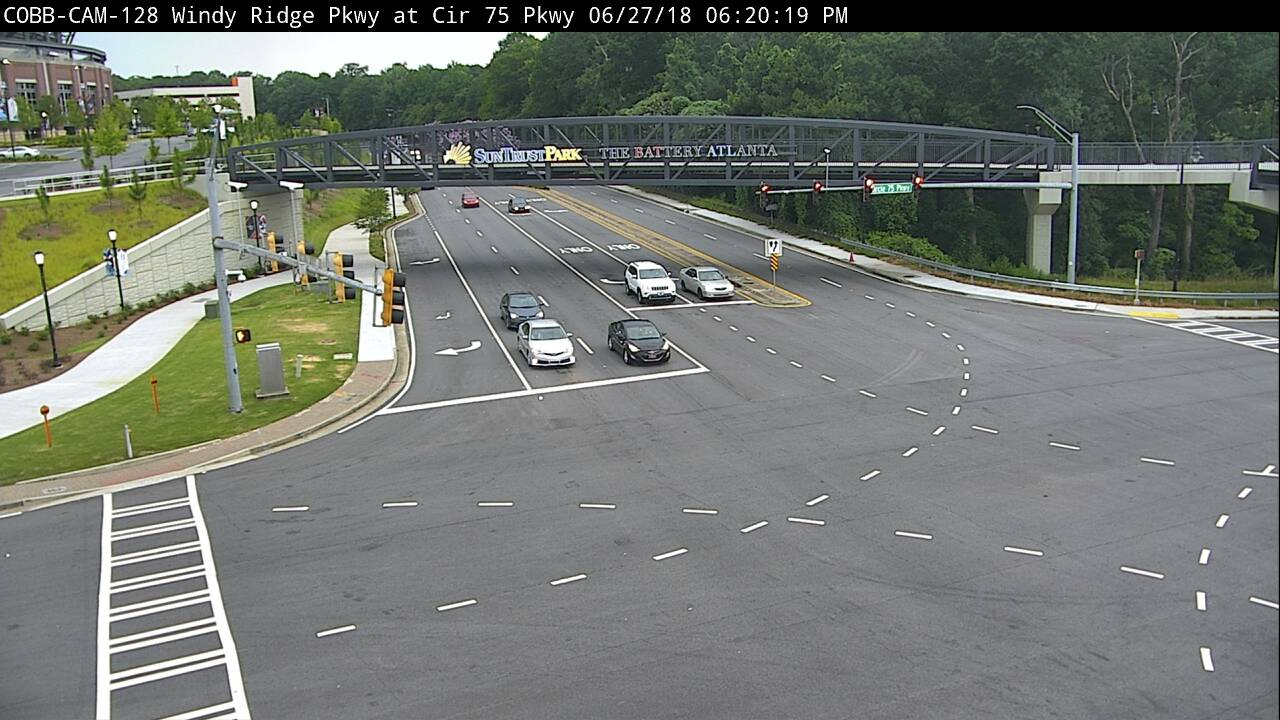

'low'

In [39]:
# Test function
test_image, test_image_url = get_latest_snapshot(cam_urls[0], workspace_dir)
Image(test_image)
test_label = classify_image(test_image, model_128_id, display_image=True)
test_label

## 2c. Update hosted service feature

In [40]:
def update_hosted_service_feature(source_label, source_camera_id, source_image_url, source_image_localpath,
                                  target_service, target_label_field, target_camera_id_field, target_source_image_field,
                                  overwrite_attachment=True, layer_index=0):
    
    # Convert our existing service into a pandas dataframe
    target_lyr = target_service.layers[layer_index]   
    target_fset = target_lyr.query(where="""camera_id = '"""+source_camera_id+"""'""", return_geometry=False)  
    all_features = target_fset.features
    original_feature = all_features[0]
    feature_to_be_updated = deepcopy(original_feature)
    
    features_for_update = []
    feature_to_be_updated.attributes[target_label_field] = source_label.capitalize()  # Use capitalize due to domain
    feature_to_be_updated.attributes[target_source_image_field] = source_image_url
    feature_to_be_updated.attributes['classification_time'] = datetime.now().strftime("%m/%d/%y %H:%M:%S")  
    
    # Store attribute updates and send edit request
    features_for_update.append(feature_to_be_updated)
    target_lyr.edit_features(updates=features_for_update) 
    
    # Perform attachment of detected image
    obj_id = feature_to_be_updated.attributes['OBJECTID']
    
    if overwrite_attachment:
        for attachment in target_lyr.attachments.get_list(obj_id):
            target_lyr.attachments.delete(obj_id, attachment['id'])

    target_lyr.attachments.add(obj_id, source_image_localpath)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


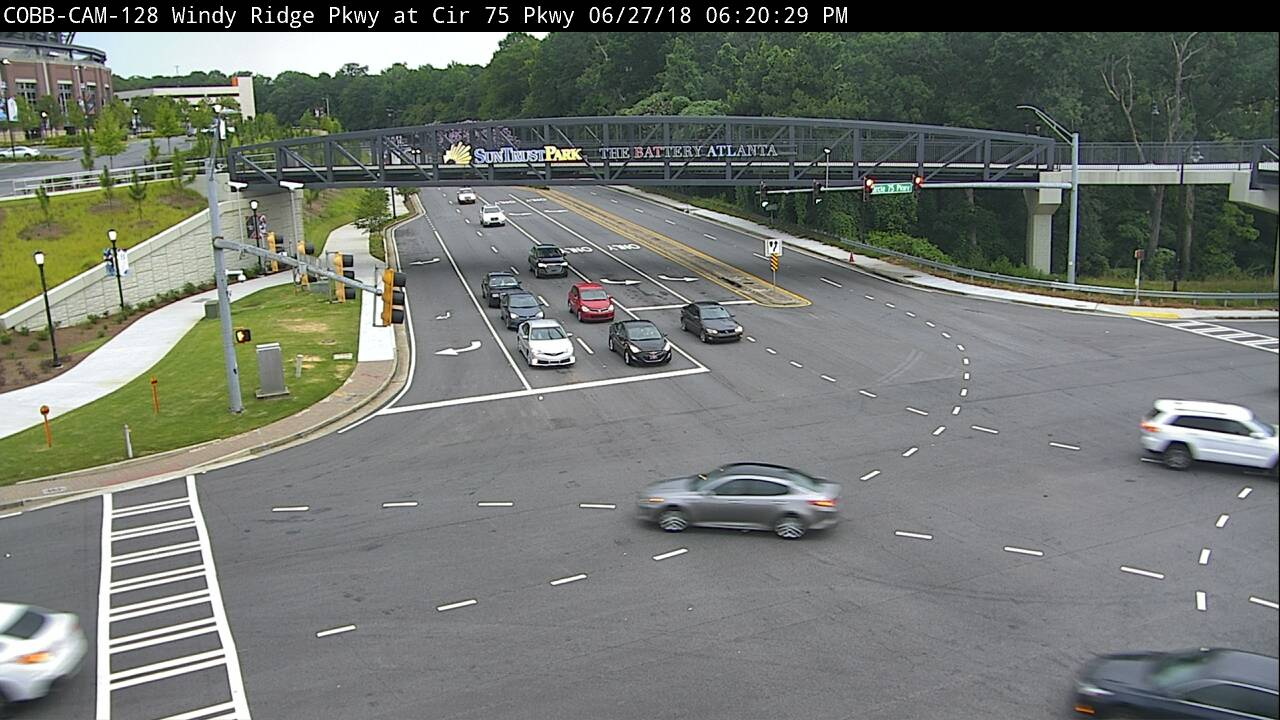

In [41]:
# Test Function
test_image, test_image_url = get_latest_snapshot(cam_urls[0], workspace_dir)
Image(test_image)
test_label = classify_image(test_image, model_128_id, display_image=True)
update_hosted_service_feature(test_label, "128", test_image_url, test_image, object_point_srvc, "pedestrian_density", "camera_id", "source_image")

## 2d. Add hosted service feature

In [42]:
# TODO
def add_hosted_service_feature(source_label, source_camera_id, source_image_url, source_image_localpath,
                               target_service, target_label_field, target_camera_id_field, target_source_image_field,
                               overwrite_attachment=True, layer_index=0):
    
    # Convert our existing service into a pandas dataframe
    target_lyr = target_service.layers[layer_index]   
    target_fset = target_lyr.query(where="""camera_id = '"""+source_camera_id+"""'""", return_geometry=False)  
    all_features = target_fset.features
    original_feature = all_features[0]
    
    features_to_be_added = []
    new_feature = deepcopy(original_feature)
    new_feature.attributes[target_label_field] = source_label.capitalize()  # Use capitalize due to domain
    new_feature.attributes[target_source_image_field] = source_image_url
    new_feature.attributes['recording_id'] = "Cam{0}_{1}".format(str(source_camera_id),
                                                                 str(datetime.now().strftime("%m%d%y_%H%M%S")))
    new_feature.attributes['classification_time'] = datetime.now().strftime("%m/%d/%y %H:%M:%S")    
    
    #add this to the list of features to be updated
    features_to_be_added.append(new_feature)
    target_lyr.edit_features(adds = features_to_be_added) 
    
    # TODO Add attachments to new features
#     obj_id = new_feature.attributes['OBJECTID']
#     object_point_lyr.attachments.add(obj_id, source_image_localpath)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


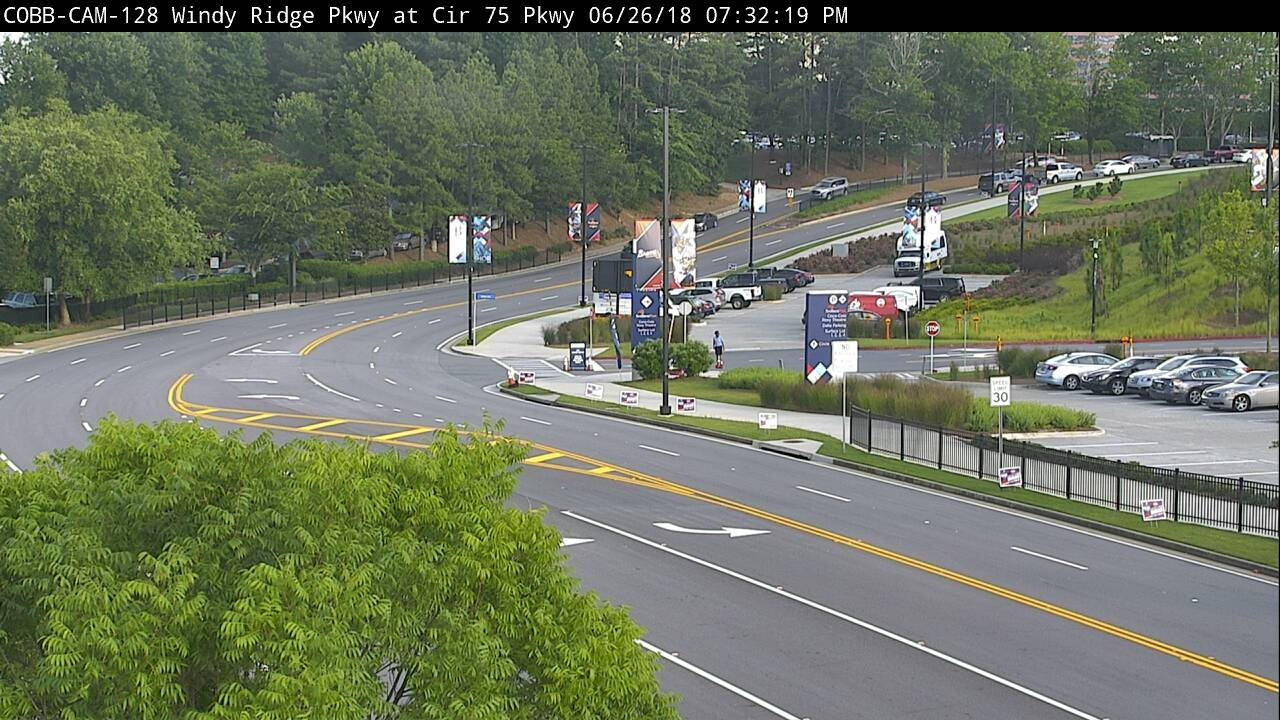

In [33]:
# Test Function
test_image, test_image_url = get_latest_snapshot(cam_urls[0], workspace_dir)
Image(test_image)
test_label = classify_image(test_image, model_128_id, display_image=True)
add_hosted_service_feature(test_label, "128", test_image_url, test_image, object_point_srvc, "pedestrian_density", "camera_id", "source_image")

# 2e. Iteration Helper (i.e. main)

In [43]:
def classify_for_time_period(camera_urls_list, time_duration, time_stride,
                                 images_webpage_url, workspace,
                                 camera_to_model_dict,
                                 target_service, target_label_field, target_camera_id_field, target_source_image_field,    
                                 threshold_val='0.15', display_image=False, overwrite_attachment=True, layer_index=0, 
                                 edit="update", verbose=False):
    
    end_time = datetime.now() + timedelta(seconds=time_duration)
    while datetime.now() < end_time:
        print("\n>>>>Performing Classification sweep at {0}<<<<".format(datetime.now()))
        
        # Iterate on each camera
        for cam_url in camera_urls_list:
            
            camera_id = cam_url[-3:]
            
            print("\nClassifying current pedestrian activity for camera {0}...".format(str(camera_id)))
            classifier_id = cameraid_model_dict[camera_id]
            if verbose:
                print("\tApplying model {0}...".format(classifier_id))
            if verbose:
                print("\tRetrieving snapshot...")
            image, image_url = get_latest_snapshot(cam_url, workspace)
            if verbose:
                print("\tClassifying snapshot...")
            try:
                label = classify_image(image, classifier_id, display_image=False)
            except Exception as e:
                print("\tWatson exception encountered. Trying again...")
                time.sleep(2)
                try:
                    label = classify_image(image, classifier_id, display_image=False)
                except Exception as e:
                    print("\tWatson exception encountered again. Bypassing observation.")
                    print(e.message)
                    label = "NA"

            if edit == "update":
                if verbose:
                    print("\tUpdating feature...")
                update_hosted_service_feature(label, camera_id, image_url, image, object_point_srvc, "pedestrian_density", "camera_id", "source_image")
            elif edit == "add":
                if verbose:
                    print("\tAdding feature...")
                add_hosted_service_feature(label, camera_id, image_url, image, object_point_srvc, "pedestrian_density", "camera_id", "source_image")
                
        # Add time_stride pause
        time.sleep(time_stride)

In [ ]:
# Test main function
camera_urls_list = cam_urls
time_duration = 60
time_stride = 10

images_webpage_url = images_url
workspace = workspace_dir
camera_to_model_dict = cameraid_model_dict

target_service = object_point_srvc
target_label_field = label_attribute_name
target_camera_id_field = camera_id_attribute_name
target_source_image_field = source_image_attribute_name

classify_for_time_period(camera_urls_list, time_duration, time_stride,
                         images_webpage_url, workspace,
                         camera_to_model_dict,
                         target_service, target_label_field, target_camera_id_field, target_source_image_field,    
                         threshold_val='0.15', display_image=False, overwrite_attachment=True, layer_index=0, 
                         edit="update", verbose=True)

# 3. Real-time Classification

## Enter duration of run in seconds

In [44]:
time_duration = 300    # five minutes
# time_duration = 3600   # One hour
# time_duration = 18000   # Six hours

In [45]:
camera_urls_list = cam_urls
time_stride = 10

images_webpage_url = images_url
workspace = workspace_dir
camera_to_model_dict = cameraid_model_dict

target_service = object_point_srvc
target_label_field = label_attribute_name
target_camera_id_field = camera_id_attribute_name
target_source_image_field = source_image_attribute_name

threshold_val = '0.15'
display_image = False
overwrite_attachment = True
layer_index = 0
edit = "update"
# edit = "add"
verbose = True

classify_for_time_period(camera_urls_list, time_duration, time_stride,
                         images_webpage_url, workspace,
                         camera_to_model_dict,
                         target_service, target_label_field, target_camera_id_field, target_source_image_field,    
                         threshold_val=threshold_val, display_image=display_image, 
                         overwrite_attachment=overwrite_attachment, layer_index=layer_index, 
                         edit=edit, verbose=verbose)


>>>>Performing Classification sweep at 2018-06-27 22:21:33.019108<<<<

Classifying current pedestrian activity for camera 128...
	Applying model Esri_Classification_CobbCounty_1256542849...
	Retrieving snapshot...


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


	Classifying snapshot...
	Updating feature...

Classifying current pedestrian activity for camera 129...
	Applying model Esri_Classification_CobbCounty_361684145...
	Retrieving snapshot...
	Classifying snapshot...
	Updating feature...

Classifying current pedestrian activity for camera 130...
	Applying model Esri_Classification_CobbCounty_371717976...
	Retrieving snapshot...
	Classifying snapshot...
	Updating feature...

>>>>Performing Classification sweep at 2018-06-27 22:22:24.161505<<<<

Classifying current pedestrian activity for camera 128...
	Applying model Esri_Classification_CobbCounty_1256542849...
	Retrieving snapshot...
	Classifying snapshot...
	Updating feature...

Classifying current pedestrian activity for camera 129...
	Applying model Esri_Classification_CobbCounty_361684145...
	Retrieving snapshot...
	Classifying snapshot...
	Updating feature...

Classifying current pedestrian activity for camera 130...
	Applying model Esri_Classification_CobbCounty_371717976...
	Retrie

KeyboardInterrupt: 